# Billboard Charts Data Exploring with Spotify Features

Billboard Hot 100 (https://www.billboard.com/charts/the-billboard-hot-100) is the most important music chart. Each week, under some metrics over streams and physical sells, the 100 most trendy songs are shown.

Once the website does not offer a file with all the charts, we can use some Web Scraping techniques, so we download it all for analysing. Here we have all Hot 100 charts since 1958 to February 2020.

After that, we will use the Spotify API to collect tracks features, so we can analyze how the top 1 track features change over the years.

Importing some basic libraries.

In [1]:
import urllib.request
from bs4 import BeautifulSoup
import re, time, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Getting charts from Billboard website via webscraping

Here we webscrape the Billboard website, so qe can get all the weekly charts published since 1957. It was made in February 2020, and after that the Billboard Archive is not available in the same structure as before, but we can see the main ideia here (the data scraped before is loaded here from the csv file we generated).
It took some hours to run, since the website naturally protects itself from robots.

In [ ]:
for year in list(range(2020,1957,-1)):

    print("\n"+str(year))

    charts = []
    
    # get all that charts that year
    url = "https://www.billboard.com/archive/charts/" + str(year) + "/HSI"
    resp = urllib.request.Request(url, headers={"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36","X-Requested-With": "XMLHttpRequest"})
    page = urllib.request.urlopen(resp)
    bs = BeautifulSoup(page,"html.parser")
    text = str(bs)

    initlink = [m.start() for m in re.finditer("href=\"/charts/hot-100/", text)]
    charts_that_year = [text[i+22:i+32] for i in initlink]

    for item in charts_that_year:
        charts.append(item)


    allcharts = pd.DataFrame({'year' : [],'month': [], 'day' : [], 'posit' : [], 'song': [], 'artist': []})
    cont = 0

    for chart_day in charts:
        cont +=1
        
        if cont%20==0:
            print("*", end="")
            time.sleep(15)
        if random.uniform(0,1) <= 0.2 and cont%20 != 0:
            print("*", end="")
            time.sleep(10)
        
        print(str(cont)+'/'+str(len(charts))+'->', end="")
        
        url = "https://www.billboard.com/charts/hot-100/" + chart_day
        resp = urllib.request.Request(url, headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36","X-Requested-With": "XMLHttpRequest"})
        page = urllib.request.urlopen(resp)
        bs = BeautifulSoup(page,"html.parser")
        text = str(bs)

        initposit= [m.start() for m in re.finditer("<span class=\"chart-element__rank__number\">", text)]
        endposit = [m.start() for m in re.finditer("</span>\n<span class=\"chart-element__trend", text)]                                          

        initsong = [m.start() for m in re.finditer("<span class=\"chart-element__information__song text--truncate color--primary\">", text)]
        endsong  = [m.start() for m in re.finditer("</span>\n<span class=\"chart-element__information__artist text--truncate color--secondary\">", text)]

        endartist = [m.start() for m in re.finditer("</span>\n<span class=\"chart-element__information__delta color--secondary\">", text)]

        posits_that_chart = []
        for i in range(len(initposit)):
            posits_that_chart.append(int(text[(initposit[i]+42):endposit[i]]))

        songs_that_chart = []
        for i in range(len(initsong)):
            songs_that_chart.append(text[(initsong[i]+77):endsong[i]])

        artists_that_chart = []
        for i in range(len(initsong)):
            artists_that_chart.append(text[(endsong[i]+89):endartist[i]])


        chartatual = pd.DataFrame({
                    'year' : np.repeat(int(chart_day[:4]),len(initposit)),
                    'month': np.repeat(int(chart_day[5:7]),len(initposit)),
                    'day':   np.repeat(int(chart_day[8:10]),len(initposit)),
                    'posit' : posits_that_chart,
                    'song': [item.replace("&amp;", "&") for item in songs_that_chart],
                    'artist': [item.replace("&amp;", "&") for item in artists_that_chart]})

        allcharts = pd.concat([allcharts, chartatual], axis=0)
        
        time.sleep(0.4)
        
    allcharts.to_csv("charts"+str(year)+".csv")
        
        

In [ ]:
charts = pd.DataFrame()
for year in range(2020,1957,-1):
    aux = pd.read_csv("charts"+str(year)+".csv")
    charts = pd.concat([charts, aux], axis=0)
charts.drop(["Unnamed: 0"], axis=1, inplace=True)

In [ ]:
charts.to_csv("charts.csv")

Let's load the data collected before.

In [2]:
charts = pd.read_csv("charts.csv", sep=";").drop("ind", 1)

In [3]:
charts.shape

(319586, 6)

Let's take a look on what the data looks like.

In [4]:
charts.head()

,year,month,day,posit,song,artist
0,2020,1,4,1,All I Want For Christmas Is You,Mariah Carey
1,2020,1,4,2,Rockin' Around The Christmas Tree,Brenda Lee
2,2020,1,4,3,Jingle Bell Rock,Bobby Helms
3,2020,1,4,4,A Holly Jolly Christmas,Burl Ives
4,2020,1,4,5,Circles,Post Malone


### Songs that kept most time on charts

Which are the songs that kept the most time on charts?

In [5]:
top100gr = charts.groupby(['song','artist'])
top100gr = top100gr.count().sort_values(by = 'posit', ascending=False)
top100gr.reset_index(level=0, inplace=True)
top100gr.reset_index(level=0, inplace=True)
top100gr.head(10)

,artist,song,year,month,day,posit
0,Imagine Dragons,Radioactive,87,87,87,87
1,AWOLNATION,Sail,78,78,78,78
2,Jason Mraz,I'm Yours,76,76,76,76
3,LeAnn Rimes,How Do I Live,69,69,69,69
4,OneRepublic,Counting Stars,68,68,68,68
5,LMFAO Featuring Lauren Bennett & GoonRock,Party Rock Anthem,67,67,67,67
6,Jewel,Foolish Games/You Were Meant For Me,65,65,65,65
7,Adele,Rolling In The Deep,64,64,64,64
8,Carrie Underwood,Before He Cheats,64,64,64,64
9,The Lumineers,Ho Hey,62,62,62,62


Note that the numerical columns lose their meaning, let's observe their values, which are the number of weeks the music was still in the charts.

Imagine Dragons kept themselves on the charts for 87 weeks with the song Radioactive!

Let's see how much time a track is on the charts in a histogram:

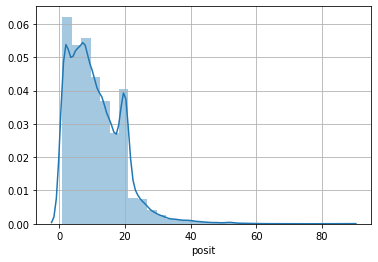

In [6]:
sns.distplot(top100gr['posit'], bins=30)
plt.grid()

We see that at 20 weeks on the charts there's an abruptal drop on the histogram.

The website defined a rule for recurrent songs: after 20 weeks on the Billboard Hot 100 and if ranking below #50, or after 52 weeks below #25 (https://www.billboard.com/p/billboard-charts-legend). The idea here it to keep the charts fresh to new songs that emerge.

Let's take a look now on the artists/groups that entered the charts the most weeks:

In [7]:
# this does not consider collaborations
tegrsingle = top100gr.groupby('artist')
tegrsingle = tegrsingle.count().sort_values(by = 'posit', ascending=False)
tegrsingle.head(10)

,song,year,month,day,posit
artist,,,,,
Glee Cast,182,182,182,182,182
Drake,90,90,90,90,90
Taylor Swift,85,85,85,85,85
The Beatles,65,65,65,65,65
Aretha Franklin,64,64,64,64,64
Elton John,58,58,58,58,58
The Rolling Stones,57,57,57,57,57
Stevie Wonder,54,54,54,54,54
The Beach Boys,53,53,53,53,53


The problem on the numbers above is that it does not count an artist when he/she is in a collaboration.

The function below define some rules to split an "artist" cell to all artists that takes part on the song.

In [8]:
def splitfeat(string):
    
    string = string.replace(' Featuring ',"/" )
    string = string.replace(' & ', "/")
    string = string.replace(' X ', "/")
    string = string.replace(', ', "/")
    string = string.replace(' And ', "/")
    string = string.replace(' + ', "/")
    
    return string

Now we finally see the artists who appeared the most weeks with most songs on the charts:

In [9]:
artists100ft = []
for item in top100gr['artist']:
    if "His Orchestra" not in item:
        listfeats = splitfeat(item).split(sep="/")
    for x in listfeats:
        artists100ft.append(x)
artists100ft = pd.DataFrame({'artist':artists100ft})

artists100ft['artist'].value_counts().head(10)

Drake           208
Glee Cast       207
Lil Wayne       160
Nicki Minaj     106
Kanye West       99
Chris Brown      98
Taylor Swift     95
Future           93
James Brown      88
Eminem           87
Name: artist, dtype: int64

### Top 1 Analysis

Now let's observe ony the songs that got to the peak.

In [10]:
charts1 = charts[charts['posit'] == 1]

In [11]:
charts1.head()

,year,month,day,posit,song,artist
0,2020,1,4,1,All I Want For Christmas Is You,Mariah Carey
100,2020,1,11,1,Circles,Post Malone
200,2020,1,18,1,The Box,Roddy Ricch
300,2020,1,25,1,The Box,Roddy Ricch
400,2020,2,1,1,The Box,Roddy Ricch


Which ones are the song that were on the top most weeks?

In [12]:
top1gr = charts1.groupby(['song','artist']).count().sort_values(by = 'posit', ascending=False)
top1gr.reset_index(level=0, inplace=True); top1gr.reset_index(level=0, inplace=True)
top1gr.head(15)

,artist,song,year,month,day,posit
0,Lil Nas X Featuring Billy Ray Cyrus,Old Town Road,19,19,19,19
1,Luis Fonsi & Daddy Yankee Featuring Justin Bieber,Despacito,16,16,16,16
2,Mariah Carey & Boyz II Men,One Sweet Day,16,16,16,16
3,Boyz II Men,I'll Make Love To You,14,14,14,14
4,Mark Ronson Featuring Bruno Mars,Uptown Funk!,14,14,14,14
5,Whitney Houston,I Will Always Love You,14,14,14,14
6,Elton John,Candle In The Wind 1997/Something About The Wa...,14,14,14,14
7,Mariah Carey,We Belong Together,14,14,14,14
8,The Black Eyed Peas,I Gotta Feeling,14,14,14,14
9,Los Del Rio,Macarena (Bayside Boys Mix),14,14,14,14


Who are the artists that put most different songs on the top?

In [13]:
#artistas com mais (diferentes) musicas em #1
top1artists = top1gr.groupby('artist').count().sort_values(by = 'posit', ascending=False)
top1artists.reset_index(level=0, inplace=True)
top1artists.head(10)

,artist,song,year,month,day,posit
0,The Beatles,19,19,19,19,19
1,Mariah Carey,16,16,16,16,16
2,Madonna,12,12,12,12,12
3,Michael Jackson,11,11,11,11,11
4,Whitney Houston,11,11,11,11,11
5,The Supremes,10,10,10,10,10
6,Bee Gees,9,9,9,9,9
7,The Rolling Stones,8,8,8,8,8
8,Janet Jackson,7,7,7,7,7
9,Stevie Wonder,7,7,7,7,7


Once more, we have to correct this data above to split artists in their collaborations

In [14]:
artists1ft = []
for item in top1gr['artist']:
    listfeats = splitfeat(item).split(sep="/")
    for x in listfeats:
        artists1ft.append(x)
artists1ft = pd.DataFrame({'artist':artists1ft})

artists1ft['artist'].value_counts().head(10)

Mariah Carey       19
The Beatles        19
Rihanna            14
Michael Jackson    12
Madonna            12
The Supremes       12
Whitney Houston    11
Bee Gees            9
Katy Perry          9
Usher               9
Name: artist, dtype: int64

Weel, it's Mariah Carey and The Beatles!

## Analyzing top 1 tracks features with Spotify API

What are the track features of the top 1 songs and how have they changed over the years?

Spotify offers in its API features to the songs, as Danceability, Loudness, Acousticness, etc. The docs here (https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) discuss the features definitions.

In [15]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import sys

In [16]:
with open("spotikey.txt",'r') as f:
    content = f.readlines()
content = [x.strip() for x in content] 
my_id = content[0]
my_token = content[1]
SPOTIPY_REDIRECT_URI = 'http://localhost:8080'
SCOPE = 'user-library-read'
CACHE = '.spotipyoauthcache'

In [17]:
client_credentials_manager = SpotifyClientCredentials(client_id=my_id, client_secret=my_token)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API

In [ ]:
def features(artist, song):
    ans = pd.DataFrame()
    
    main_artist = splitfeat(artist).split(sep="/")[0]
    
    spotifyresults = sp.search(q='artist:' + main_artist + " track:" + song, type='track') 
    if len(spotifyresults['tracks']['items']) > 0:
        try:
            #print(artist+" - "+song)
            trackuri = spotifyresults['tracks']['items'][0]['uri']
            features = pd.DataFrame(sp.audio_features(tracks = trackuri))
            #print(features)
            for k in keys:
                #print(k+"-"+features[k])
                ans[k] = features[k]
        except:
            #print("nao consegue acessar valores")
            for k in keys:
                ans[k] = np.nan  
    else:
        print("resultados vazios")
        for k in keys:
            ans[k] = np.nan  
    
    return ans

In this function we search the track features for each one of the top 1 tracks. We will load the csv generated here.

In [ ]:
keys = list(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
             'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
             'type', 'uri', 'duration_ms', 'time_signature'])

aux1 = pd.DataFrame()
ii=0

for index, item in charts1.iterrows():
    ii+=1
    if ii%10 == 0:
        print(str(ii)+"/"+str(charts1.shape[0])+"-", end="")
    
    main_artist = splitfeat(item['artist']).split(sep="/")[0]
    track = item['song']
    
    aux2 = pd.DataFrame(columns = keys)
    
    spotifyresults = sp.search(q='artist:' + main_artist + " track:" + track, type='track') 
    if len(spotifyresults['tracks']['items']) > 0:
        try:
            #print(item['artist']+"-"+item['song'])
            trackuri = spotifyresults['tracks']['items'][0]['uri']
            features = sp.audio_features(tracks = trackuri)[0]
            for k in keys:
                aux2[k] = [features[k]]
        except:
            for k in keys:
                aux2[k] = [np.nan]
    else:
        for k in keys:
            aux2[k] = [np.nan] 
    
    aux1 = pd.concat([aux1, aux2], axis=0)

In [ ]:
aux1.reset_index(drop=True, inplace=True)
aux1.head(15)

In [ ]:
charts1.reset_index(drop=True, inplace=True)
charts1.head(15)

In [ ]:
charts1 = pd.concat([charts1, aux1], axis=1, ignore_index=False)

In [ ]:
charts1.to_csv("charts1.csv")

In [18]:
charts1 = pd.read_csv("charts1.csv")

In [20]:
charts1.shape

(3196, 23)

Weel, let's calculate the mean of each feature over the years and see how listeners taste has changed.

We will remove the duplicates. We'll make this so a song that kept much time on the top does not dominate the mean over one year.

In [23]:
table = pd.pivot_table(charts1.drop_duplicates(subset=['artist','song']), values=['danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'uri',
       'duration_ms', 'time_signature'], index=['year'],
                    columns=[], aggfunc=np.mean)
table.tail()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
year,,,,,,,,,,,,,
2016.0,0.215673,0.656222,225616.444444,0.600111,0.000368,6.222222,0.194633,-5.824889,0.555556,0.140478,112.160556,4.000000,0.471000
2017.0,0.166031,0.776556,237969.888889,0.640333,0.000016,4.111111,0.113889,-5.581444,0.555556,0.129878,145.002000,4.000000,0.519889
2018.0,0.192848,0.762182,229447.818182,0.598909,0.000364,5.454545,0.229000,-5.984818,0.909091,0.104200,110.250273,3.909091,0.459182
2019.0,0.284566,0.685143,187304.928571,0.513500,0.009292,4.714286,0.125893,-6.806143,0.571429,0.103171,122.289929,4.000000,0.473236
2020.0,0.153333,0.642000,217680.000000,0.657667,0.000813,5.666667,0.315700,-5.882000,0.666667,0.044667,129.096667,4.000000,0.513667


To give us an idea of the tendency, we'll plot a spline over the data. Each spline is adjusted manually, once here we do not have the intention to perform regression analysis. The next functions define these splines.

In [24]:
from scipy.interpolate import UnivariateSpline

In [25]:
def plot_feature(key, ax, smoothing):
    
    spl = UnivariateSpline(list(table.index), table[key])
    xs = np.linspace(1957, 2020, 1000)
    spl.set_smoothing_factor(smoothing)
    
    ax.plot(xs, spl(xs), 'r', lw=2)

    ax.plot(list(table.index), table[key])
    ax.title.set_text(key)

    ax.grid()

#### Danceability, Energy, Valence, Tempo

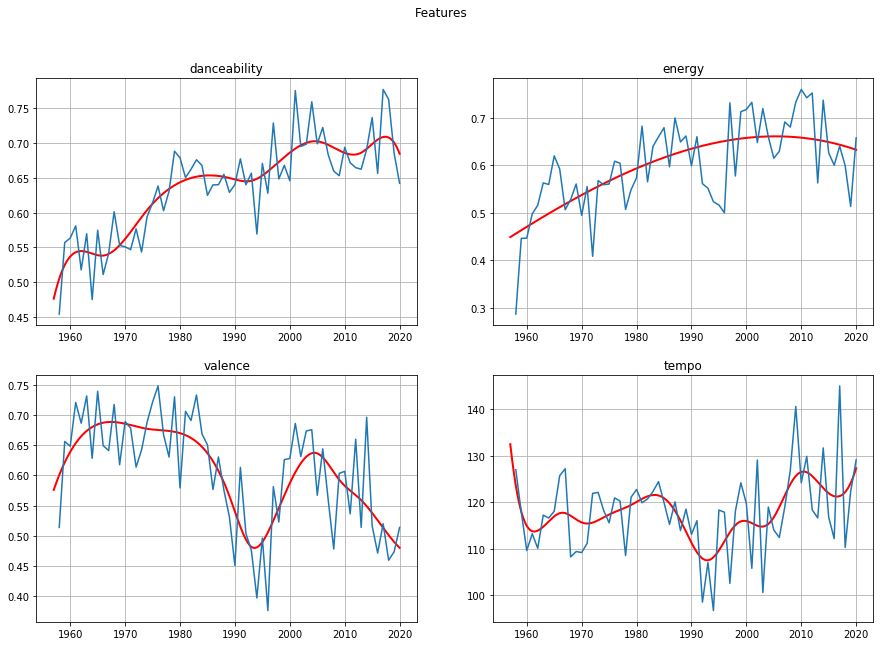

In [26]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Features')
plot_feature("danceability", axs[0,0], 0.07)
plot_feature("energy", axs[0,1], 0.5)
plot_feature("valence", axs[1,0], 0.2)
plot_feature("tempo", axs[1,1], 3100)

We see that for Danceability and Energy there's an overall increasing tendency.

For Valence, which is a measure of positivy (happiness, cheerfulness, euphoria vs. sadness, angriness and depression), we see that the 90s were sadder years for the listeners... a behavior that is being replicated in the 2010s.

For Tempo (BPMs), we see a slight increase in the 2010s.

#### Acousticness, Instrumentalness, Liveness, Speechiness

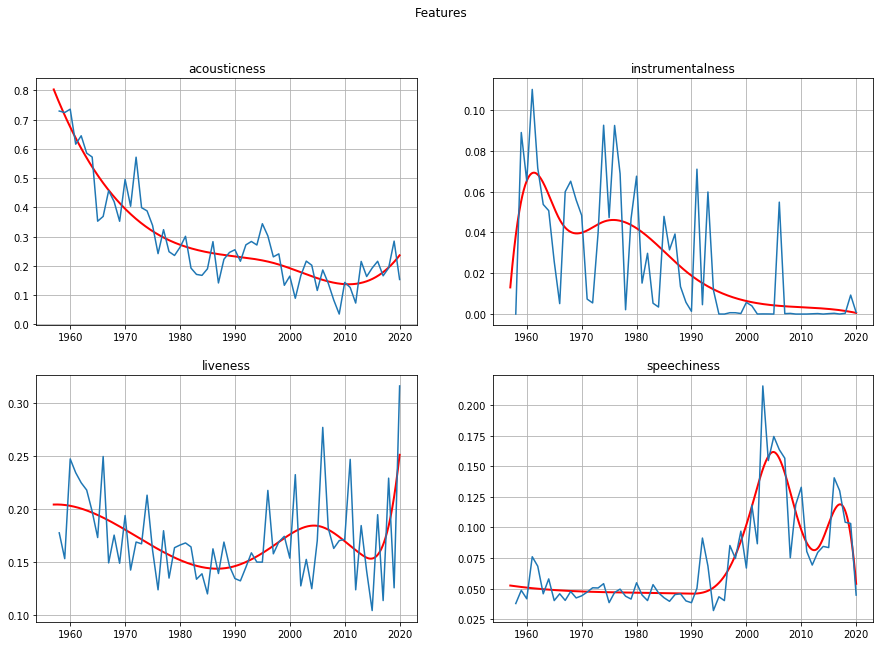

In [27]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Features')
plot_feature("acousticness", axs[0,0], 0.25)
plot_feature("instrumentalness", axs[0,1], 0.03)
plot_feature("liveness", axs[1,0], 0.075)
plot_feature("speechiness", axs[1,1], 0.02)

We see the top 1 songs were less acoustic over the years, and of much less instumental characteristics too.

Liveness (presence of audience) does not show much of a pattern.

There is a peak of Speechiness in the 2000s, probably justified by the rap/hip-hop  ascencion in the decade.

#### Duration, Loudness

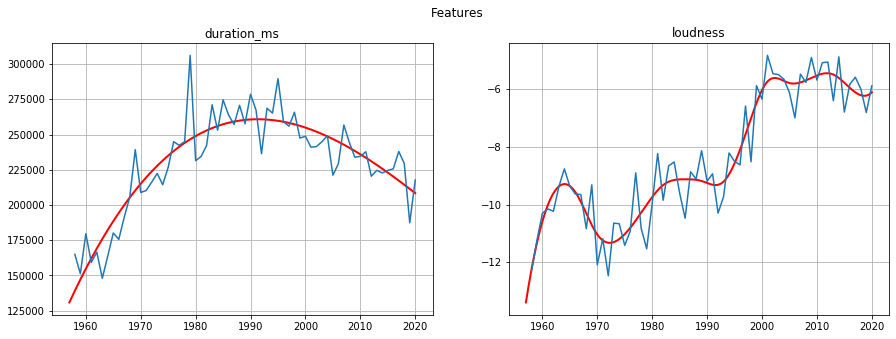

In [29]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Features')
plot_feature("duration_ms", axs[0], 10**11)
plot_feature("loudness", axs[1], 30)

For some reason, the tracks duration increased until around 1990, when it began to consistently drop.

The Loudness (in dB) had a great increase in the 1990s too.

#### Key, Mode

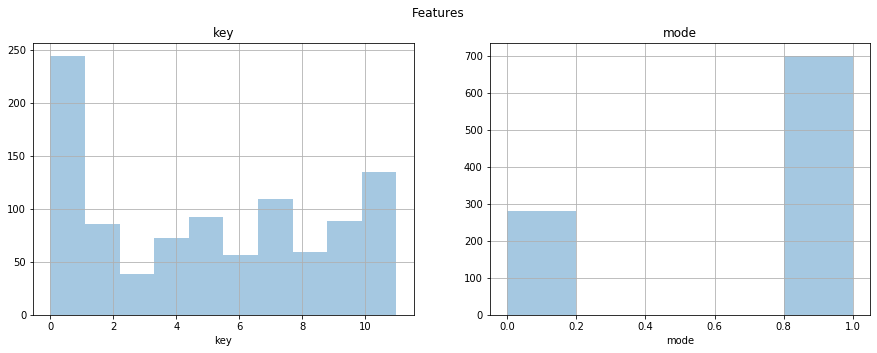

In [30]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Features')

sns.distplot(charts1.drop_duplicates(subset=['artist','song'])['key'].dropna(),  ax=axs[0], kde=False)
axs[0].grid()
axs[0].title.set_text("key")

sns.distplot(charts1.drop_duplicates(subset=['artist','song'])['mode'].dropna(), ax=axs[1], kde=False)
axs[1].grid()
axs[1].title.set_text("mode")

Over all the years, the most used Key was C.

Most of the songs was in Major, which generally defines happier songs.

# Conclusion

In this notebook, I trained a simple Web Scraping technique and used the Spotify API to collect features informations about the tracks from Billboard Hot 100.

In general, from the features behaviours, we see that tracks in the top of the chart have been getting more danceable and energetic on average. For some reason the tracks duration have increased until 1990, and then began to fall. In the 2010s we see a clear increase in speechiness, derived from the rap/hip-hop trend.

For future works, it is interesting to observe how the lyrics have changed: what is the vocabulary of each decade, the complexity of them and even create a lyrics generator for a Hot 100 song.

---------
Regards,

Lucas Silva
